In [60]:
import numpy as np
import librosa
import librosa.display
import csv
import pandas as pd

import itertools
import os
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [18]:
M = lambda x: np.mean(x)

In [31]:
zero_crossing_rate = lambda x: M(librosa.feature.zero_crossing_rate(x, pad=False)) 
spectral_centroid = lambda x: M(librosa.feature.spectral_centroid(x))
chroma_stft = lambda x: M(librosa.feature.chroma_stft(x, pad=False))
spectral_bw = lambda x: M(librosa.feature.spectral_bandwidth(x))
spectral_rolloff = lambda x: M(librosa.feature.spectral_rolloff(x))
mfcc = lambda x: librosa.feature.mfcc(x)
def create_line(file_name, sg, genre):
    line = f' {file_name} {zero_crossing_rate(sg)} {spectral_centroid(sg)} {spectral_bw(sg)} {spectral_rolloff(sg)}'
    A = mfcc(sg)
    for y in A:
        line += f' {M(y)}'
    line += f' {genre}'
    return line

In [38]:
data_path = '/Users/jadhamdan/Desktop/Final Project/data.csv'
header = '.. .. filename zero_crossing_rate spectral_centroid spectral_bandwidth spectral_rolloff'
for i in range(1,21):
    header += f' mfcc{i}' 
header += ' label'
header = header.split()

In [39]:
file = open(data_path, 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
        'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}
for x,_ in genres.items():
    folder = source + x

    for root, subdirs, files in os.walk(folder):
        for file in files:
            file_name = folder + "/" + file
            sg, sr = librosa.load(file_name, mono=True, duration=30)
            
            line = create_line(file_name, sg, x)
            file = open(data_path, 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(line.split())

In [46]:
data = pd.read_csv(data_path)
data.drop(data.columns[[0]], axis=1, inplace=True)
data.drop(data.columns[[0]], axis=1, inplace=True)
data.drop(data.columns[[0]], axis=1, inplace=True)
data.head()

,zero_crossing_rate,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.046570,1443.678582,1726.412512,3286.321795,-90.707569,128.052067,-34.784228,73.780840,4.324888,28.106828,...,5.680119,-6.765613,-0.474510,-0.283712,5.873021,-3.958959,-1.296033,3.513313,-1.251131,metal
1,0.108007,2375.812595,2231.960229,4898.745378,-66.648848,88.340498,-27.537220,53.171481,-9.188600,27.955177,...,13.676217,-8.358881,7.963045,-6.292233,8.112967,-4.970684,6.161912,0.377701,2.701730,metal
2,0.092420,1988.120374,1986.988534,4148.191583,-129.700196,104.034397,-26.972440,68.271098,2.435363,22.608912,...,5.377908,-3.004201,2.977995,-5.836916,3.937055,-6.004716,-1.969018,2.388182,-3.851088,metal
3,0.115765,2241.314038,2115.702650,4490.464513,-95.311522,92.069453,-28.057869,52.800290,-3.014751,25.402716,...,11.697475,-9.264784,2.808078,-4.432126,5.501777,-6.275822,3.836044,-0.416936,4.665856,metal
4,0.169265,2986.705162,2459.025706,5818.223151,-76.752619,68.002615,-11.241135,76.365832,-17.468196,25.335778,...,12.519486,-18.505018,10.831523,-13.698643,4.864020,-11.976661,1.647740,-7.643869,2.225926,metal


In [55]:
enc = LabelEncoder()
sc = StandardScaler()
y = enc.fit_transform(data.iloc[:, -1])
X = sc.fit_transform(np.array(data.iloc[:,:-1], dtype=float))
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

In [56]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(850, 24) (850,)
(150, 24) (150,)


In [61]:
classifier = svm.SVC(kernel='linear' , C=0.01)
classifier.fit(X_train, y_train)
prediction_SVM = classifier.predict(X_test)
classifier.score(X_test, y_test)

0.42

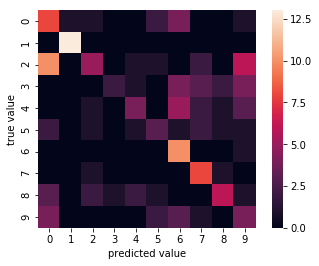

In [62]:
import seaborn as sns
mat = confusion_matrix(y_test, prediction_SVM)
sns.heatmap(mat, square=True, annot=False, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

0.54


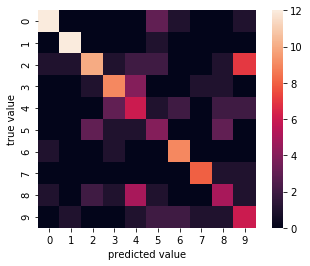

In [65]:
random_forest = RandomForestClassifier(n_estimators=15,)
random_forest.fit(X_train,y_train)
print(random_forest.score(X_test,y_test))
prediction_RF = random_forest.predict(X_test)
mat2 = confusion_matrix(y_test, prediction_RF)
sns.heatmap(mat2, square=True, annot=False, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

0.30666666666666664


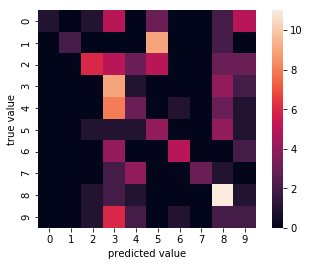

In [67]:
AdaBoost = AdaBoostClassifier(learning_rate=0.1)
AdaBoost.fit(X_train, y_train)
print(AdaBoost.score(X_test, y_test))
prediction_AdaBoost = AdaBoost.predict(X_test)
mat3 = confusion_matrix(y_test, prediction_AdaBoost)
sns.heatmap(mat3, square=True, annot=False, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

In [92]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=128)

Epoch 1/50
850/850 [==============================] - 1s 611us/step - loss: 2.1940 - acc: 0.2165
Epoch 2/50
850/850 [==============================] - 0s 27us/step - loss: 1.9031 - acc: 0.3541
Epoch 3/50
850/850 [==============================] - 0s 22us/step - loss: 1.6885 - acc: 0.4012
Epoch 4/50
850/850 [==============================] - 0s 26us/step - loss: 1.5289 - acc: 0.4541
Epoch 5/50
850/850 [==============================] - 0s 21us/step - loss: 1.3920 - acc: 0.5012
Epoch 6/50
850/850 [==============================] - 0s 23us/step - loss: 1.2849 - acc: 0.5541
Epoch 7/50
850/850 [==============================] - 0s 26us/step - loss: 1.2113 - acc: 0.5812
Epoch 8/50
850/850 [==============================] - 0s 25us/step - loss: 1.1241 - acc: 0.6129
Epoch 9/50
850/850 [==============================] - 0s 25us/step - loss: 1.0663 - acc: 0.6388
Epoch 10/50
850/850 [==============================] - 0s 27us/step - loss: 1.0021 - acc: 0.6694
Epoch 11/50
850/850 [=================

In [93]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(test_accuracy)

150/150 [==============================] - 0s 984us/step
0.6733333293596904
